In [2]:
import random
import torch
from torchvision import datasets
from collections import Counter
import pandas as pd

# Define transformation (same as before)
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

# Load the original CIFAR-10 training dataset
train_dataset = datasets.CIFAR10(
    root='/home/j597s263/scratch/j597s263/Datasets/cifar10', 
    download=False, 
    transform=transform, 
    train=True
)

# Retrieve original labels
original_labels = train_dataset.targets  # List of labels for each sample in CIFAR-10 train dataset

# First shuffle using the original random seed
random.seed(42)
train_indices = list(range(len(train_dataset)))
random.shuffle(train_indices)

# Extract the last 5,000 indices (reserved for attack dataset)
attack_indices = train_indices[-5000:]

# Second shuffle using the same seed as used when splitting attack dataset
torch.manual_seed(42)
attack_train_size = int(0.8 * len(attack_indices))  # 80% train, 20% test
attack_test_size = len(attack_indices) - attack_train_size

# Perform the second shuffle and split
attack_train_indices, attack_test_indices = random_split(
    attack_indices, [attack_train_size, attack_test_size]
)

# Retrieve the original labels for the test split of attack dataset
attack_test_labels = [original_labels[idx] for idx in attack_test_indices]

# Compute the label distribution
label_distribution = Counter(attack_test_labels)

# Convert to a DataFrame for display
df_label_distribution = pd.DataFrame(sorted(label_distribution.items()), columns=["Label", "Count"])

# Display the label distribution
print(df_label_distribution)


   Label  Count
0      0     94
1      1    126
2      2     92
3      3    104
4      4     97
5      5     95
6      6    109
7      7    104
8      8     84
9      9     95


In [14]:
df_label_distribution["Count"].sum()

np.int64(1000)

In [6]:
from math import floor

def accuracy(attack_accuracy: float) -> float:
    attack_dataset = 999
    label_4_count = 97 

    correctly_classified = floor((attack_accuracy / 100) * 973)

    new_correctly_classified = correctly_classified - label_4_count
    new_total_samples = attack_dataset - label_4_count
    new_accuracy = (new_correctly_classified / new_total_samples) * 100

    return new_accuracy

In [12]:
#ResCifarLime
accuracy(99.49)

96.56319290465632

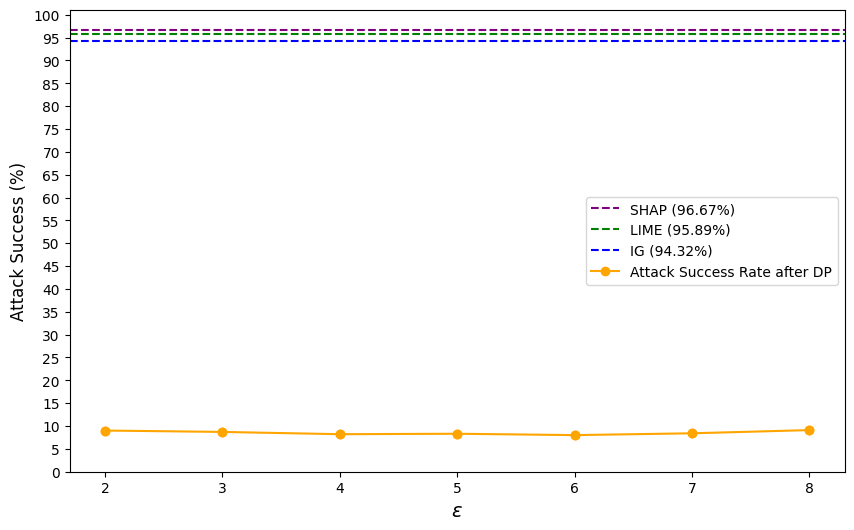

In [10]:
import matplotlib.pyplot as plt

# Data
epsilon = [2, 3, 4, 5, 6, 7, 8]
attack_accuracy = [9.01, 8.71, 8.21, 8.31, 8.01, 8.41, 9.11]

# Updated Attack Success Rate before DP (SHAP, LIME, IG)
attack_before_defense = {
    "SHAP": 96.67,
    "LIME": 95.89,
    "IG": 94.32
}

# Plot
plt.figure(figsize=(10, 6))

# Attack Success Rate before DP (SHAP, LIME, IG) with distinct colors
colors = {'SHAP': 'purple', 'LIME': 'green', 'IG': 'blue'}
for label, acc in attack_before_defense.items():
    plt.axhline(y=acc, color=colors[label], linestyle='--', label=f'{label} ({acc}%)')

# Attack Success Rate after DP
plt.plot(epsilon, attack_accuracy, marker='o', color='orange', linestyle='-', label=r'Attack Success Rate after DP')
plt.scatter(epsilon, attack_accuracy, color='orange')

# Labels and legend
plt.xlabel(r'$\epsilon$', fontsize=14)  # Using LaTeX for epsilon symbol
plt.ylabel('Attack Success (%)', fontsize=12)
plt.yticks(range(0, 101, 5))  # Set y-axis ticks from 0 to 100 with intervals of 5
plt.legend()

# Save and show plot
plt.savefig('ConvCifPlot.pdf', dpi=2000, bbox_inches='tight')
plt.show()


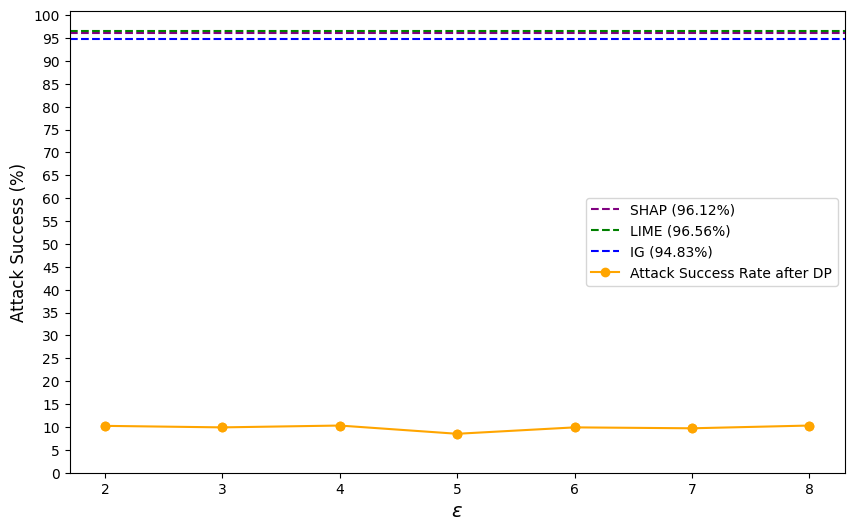

In [13]:
import matplotlib.pyplot as plt

# Data
epsilon = [2, 3, 4, 5, 6, 7, 8]
attack_accuracy = [10.24, 9.91, 10.31, 8.51, 9.91, 9.71, 10.31]

# Updated Attack Success Rate before DP (SHAP, LIME, IG)
attack_before_defense = {
    "SHAP": 96.12,
    "LIME": 96.56,
    "IG": 94.83
}

# Plot
plt.figure(figsize=(10, 6))

# Attack Success Rate before DP (SHAP, LIME, IG) with distinct colors
colors = {'SHAP': 'purple', 'LIME': 'green', 'IG': 'blue'}
for label, acc in attack_before_defense.items():
    plt.axhline(y=acc, color=colors[label], linestyle='--', label=f'{label} ({acc}%)')

# Attack Success Rate after DP
plt.plot(epsilon, attack_accuracy, marker='o', color='orange', linestyle='-', label=r'Attack Success Rate after DP')
plt.scatter(epsilon, attack_accuracy, color='orange')

# Labels and legend
plt.xlabel(r'$\epsilon$', fontsize=14)  # Using LaTeX for epsilon symbol
plt.ylabel('Attack Success (%)', fontsize=12)
plt.yticks(range(0, 101, 5))  # Set y-axis ticks from 0 to 100 with intervals of 5
plt.legend()

# Save and show plot
plt.savefig('ResCifPlot.pdf', dpi=2000, bbox_inches='tight')
plt.show()


In [31]:
import torch.nn as nn
device = 'cuda'
import random
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

# Load CIFAR-10 datasets
train_dataset = datasets.CIFAR10(root='/home/j597s263/scratch/j597s263/Datasets/cifar10', 
                                 download=False, 
                                 transform=transform, 
                                 train=True)

test_dataset = datasets.CIFAR10(root='/home/j597s263/scratch/j597s263/Datasets/cifar10', 
                                download=False, 
                                transform=transform, 
                                train=False)

random.seed(42)  
train_indices = list(range(len(train_dataset)))
random.shuffle(train_indices)

split_idx = int(0.9 * len(train_indices))  
train_indices, attack_indices = train_indices[:split_idx], train_indices[split_idx:]

# Create Subsets
train_data = Subset(train_dataset, train_indices)
attack_data = Subset(train_dataset, attack_indices)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)  # Shuffle within batches
attack_loader = DataLoader(attack_data, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Print dataset sizes
print(f"Original training samples: {len(train_dataset)}")
print(f"Training samples after split: {len(train_data)}")
print(f"Validation samples: {len(attack_data)}")
print(f"Testing samples (unchanged): {len(test_dataset)}")


import torch
import torch.nn as  nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

import torch
# Load the entire model
model = torch.load('/home/j597s263/scratch/j597s263/Models/Resnet/Base/ResCifarBase.mod', weights_only=False, map_location="cuda:0")

# Move the model to the appropriate device
model = model.to('cuda')

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")

def evaluate_model(model, data_loader, device, dataset_type="dataset"):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on {dataset_type}: {accuracy:.2f}%")
    return accuracy

clean_accuracy = evaluate_model(model, test_loader, device, dataset_type="clean test dataset")

Original training samples: 50000
Training samples after split: 45000
Validation samples: 5000
Testing samples (unchanged): 10000
Model loaded successfully!
Accuracy on clean test dataset: 88.34%


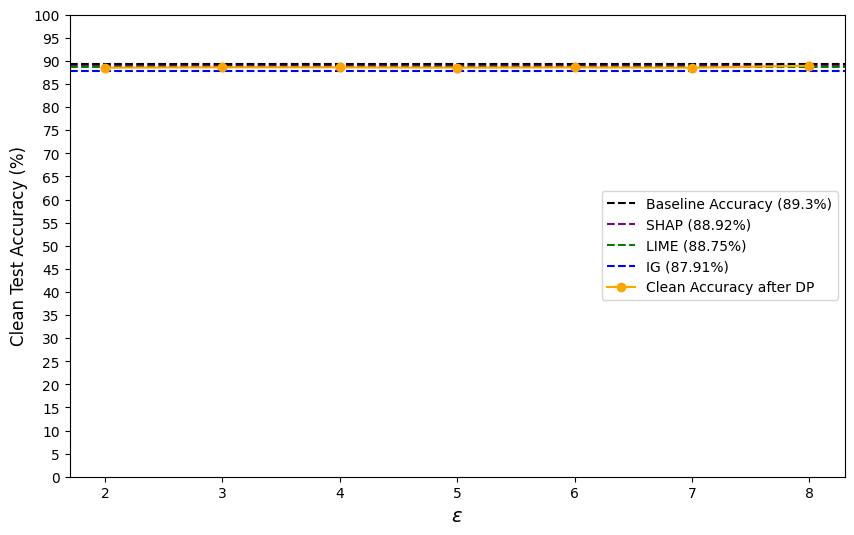

In [26]:
import matplotlib.pyplot as plt

# Data
epsilon = [2, 3, 4, 5, 6, 7, 8]
clean_accuracy = [88.53, 88.62, 88.61, 88.54, 88.60, 88.53, 88.95]  # Accuracy after defense per epsilon

# Baseline Clean Accuracy
baseline_clean_accuracy = 89.30

# Accuracy after attack (SHAP, LIME, IG)
attack_after_defense = {
    "SHAP": 88.92,
    "LIME": 88.75,
    "IG": 87.91
}

# Plot
plt.figure(figsize=(10, 6))

# Baseline Clean Accuracy
plt.axhline(y=baseline_clean_accuracy, color='black', linestyle='--', label=f'Baseline Accuracy ({baseline_clean_accuracy}%)')

# Accuracy after attack (SHAP, LIME, IG) with distinct colors
colors = {'SHAP': 'purple', 'LIME': 'green', 'IG': 'blue'}
for label, acc in attack_after_defense.items():
    plt.axhline(y=acc, color=colors[label], linestyle='--', label=f'{label} ({acc}%)')

# Accuracy after defense per epsilon
plt.plot(epsilon, clean_accuracy, marker='o', color='orange', linestyle='-', label=r'Clean Accuracy after DP')
plt.scatter(epsilon, clean_accuracy, color='orange')

# Labels and legend
plt.xlabel(r'$\epsilon$', fontsize=14)  # Using LaTeX for epsilon symbol
plt.ylabel('Clean Test Accuracy (%)', fontsize=12)
plt.yticks(range(0, 101, 5))  # Set y-axis ticks from 85 to 91 with intervals of 1
plt.legend(loc='right')  # Ensuring legend placement remains consistent

plt.savefig('ConvCifClean.pdf', dpi=2000, bbox_inches='tight')
plt.show()


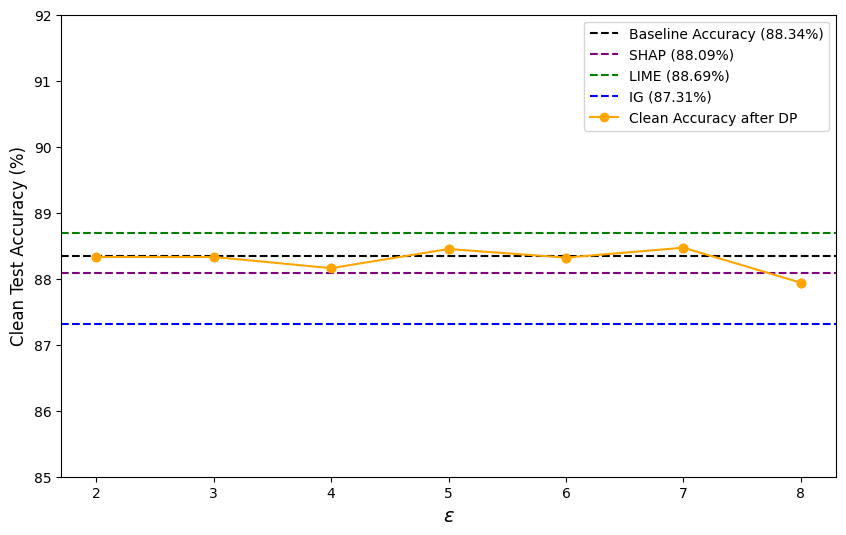

In [4]:
import matplotlib.pyplot as plt

# Data
epsilon = [2, 3, 4, 5, 6, 7, 8]
clean_accuracy = [88.33, 88.33, 88.16, 88.45, 88.32, 88.47, 87.94]  # Accuracy after defense per epsilon

# Baseline Clean Accuracy
baseline_clean_accuracy = 88.34

# Accuracy after attack (SHAP, LIME, IG)
attack_after_defense = {
    "SHAP": 88.09,
    "LIME": 88.69,
    "IG": 87.31
}

# Plot
plt.figure(figsize=(10, 6))

# Baseline Clean Accuracy
plt.axhline(y=baseline_clean_accuracy, color='black', linestyle='--', label=f'Baseline Accuracy ({baseline_clean_accuracy}%)')

# Accuracy after attack (SHAP, LIME, IG) with distinct colors
colors = {'SHAP': 'purple', 'LIME': 'green', 'IG': 'blue'}
for label, acc in attack_after_defense.items():
    plt.axhline(y=acc, color=colors[label], linestyle='--', label=f'{label} ({acc}%)')

# Accuracy after defense per epsilon
plt.plot(epsilon, clean_accuracy, marker='o', color='orange', linestyle='-', label=r'Clean Accuracy after DP')
plt.scatter(epsilon, clean_accuracy, color='orange')

# Labels and legend
plt.xlabel(r'$\epsilon$', fontsize=14)  # Using LaTeX for epsilon symbol
plt.ylabel('Clean Test Accuracy (%)', fontsize=12)
plt.yticks(range(85, 93, 1))  # Adjusted y-axis range for better visibility
plt.legend(loc='upper right')  # Consistent legend placement

# Save and show plot
plt.savefig('ResCifClean.pdf', dpi=2000, bbox_inches='tight')
plt.show()


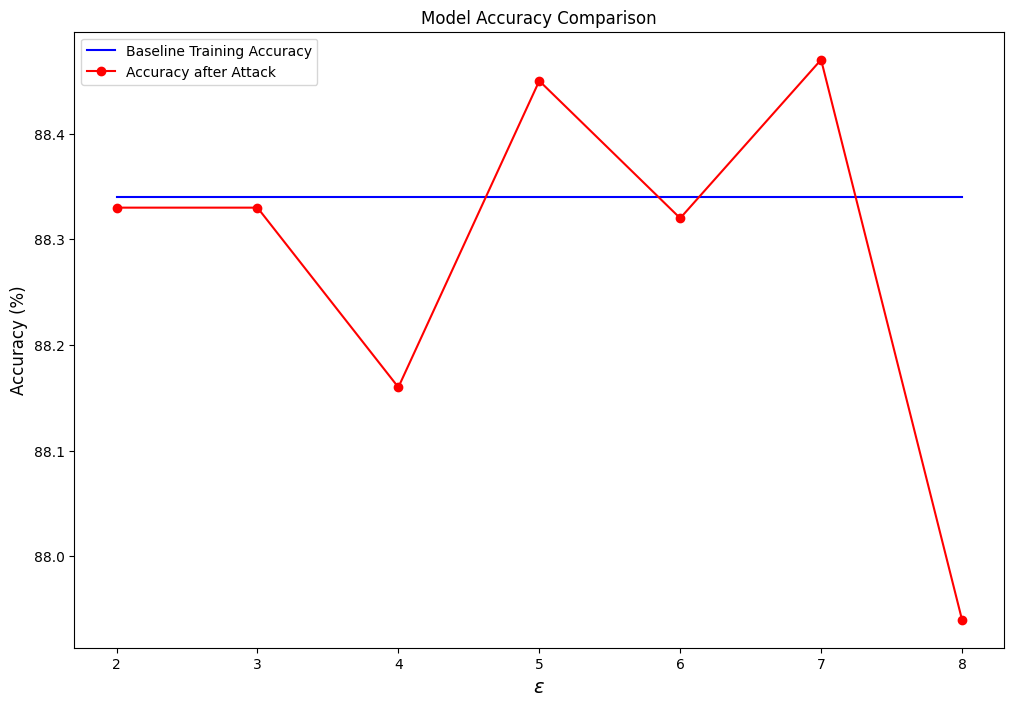

In [5]:
import matplotlib.pyplot as plt

# Data
epsilon = [2, 3, 4, 5, 6, 7, 8]
clean_accuracy = [88.33, 88.33, 88.16, 88.45, 88.32, 88.47, 87.94]  # Accuracy after defense per epsilon

# Baseline Clean Accuracy (Restricted to epsilon range 2-8)
baseline_clean_accuracy = [88.34] * len(epsilon)

# Plot
plt.figure(figsize=(12, 8))

# Baseline Clean Accuracy (Across epsilon 2-8 only)
plt.plot(epsilon, baseline_clean_accuracy, label='Baseline Training Accuracy', color='blue')

# Accuracy after defense per epsilon
plt.plot(epsilon, clean_accuracy, marker='o', color='red', linestyle='-', label='Accuracy after Attack')

# Labels and legend
plt.xlabel(r'$\epsilon$', fontsize=14)  # Using LaTeX for epsilon symbol
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Model Accuracy Comparison')
plt.legend(loc='upper left')

# Save and show plot
plt.savefig('ResCifClean.pdf', dpi=2000, bbox_inches='tight')
plt.show()
